In [1]:
import numpy as np
from scipy.constants import c, Boltzmann
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy import signal

import pickle
import sympy as sp
%matplotlib ipympl
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.sparse import csr_matrix
from joblib import Parallel, delayed

In [2]:
import os

parent_dir = os.path.dirname(os.getcwd())
print(parent_dir)  # Prints parent directory

os.chdir(parent_dir)
#print(os.getcwd())  # Prints current working directory

import mmars

c:\Users\rasmu\Documents\GitHub\MMARS


In [3]:
radar_model_1 = mmars.FmcwRadar(position=np.array([[-1.5,0]]), signalNoiseRatio=[10, 10], N_chirps=1)
radar_model_2 = mmars.FmcwRadar(position=np.array([[0,0]]), signalNoiseRatio=[10, 10], N_chirps=1)
radar_model_3 = mmars.FmcwRadar(position=np.array([[1.5,0]]), signalNoiseRatio=[10, 10], N_chirps=1)

## Setting up the target

In [4]:
T_frame = 0.1
target_model_1 = mmars.Target(start_position=np.array([[0.,5.]]), start_velocity=1., T_total=90., T_frame=T_frame)
target_model_1.generate_trajectory(trajectory_type="sinusoidal")
target_ground_truth = target_model_1.get_trajectory()
mrblatcomp = mmars.MRBLaT_Functions(radar_model_1.get_parameters)

In [5]:
simulation_data_1 = mmars.Simulation(radar_model_1, target_model_1)
simulation_data_1.run()
simulation_data_2 = mmars.Simulation(radar_model_2, target_model_1)
simulation_data_2.run()
simulation_data_3 = mmars.Simulation(radar_model_3, target_model_1)
simulation_data_3.run()

Running simulation with <mmars.fmcwRadar.FmcwRadar object at 0x000001C9A4B361D0> and <mmars.target.Target object at 0x000001C9E6D3DDD0>


100%|██████████| 900/900 [00:00<00:00, 952.99it/s]


Running simulation with <mmars.fmcwRadar.FmcwRadar object at 0x000001C9E7F53450> and <mmars.target.Target object at 0x000001C9E6D3DDD0>


100%|██████████| 900/900 [00:00<00:00, 953.05it/s]


Running simulation with <mmars.fmcwRadar.FmcwRadar object at 0x000001C9E7EABA50> and <mmars.target.Target object at 0x000001C9E6D3DDD0>


100%|██████████| 900/900 [00:00<00:00, 994.25it/s]


In [6]:
sim_data_1 = simulation_data_1.get_data()
sim_data_2 = simulation_data_2.get_data()
sim_data_3 = simulation_data_3.get_data()

# MRBLaT

In [ ]:
multi_radar = mmars.Tracking([sim_data_1,sim_data_2,sim_data_3], [radar_model_1.get_parameters,radar_model_2.get_parameters,radar_model_3.get_parameters], np.array([[target_ground_truth[0][0]], [target_ground_truth[1][0]], [target_ground_truth[2][0]], [target_ground_truth[3][0]]]))
single_radar = mmars.Tracking([sim_data_1], [radar_model_1.get_parameters], np.array([[target_ground_truth[0][0]], [target_ground_truth[1][0]], [target_ground_truth[2][0]], [target_ground_truth[3][0]]]))

In [ ]:
multi_phi_bar, multi_phi_barbar = multi_radar.run_mrblat(T_frame, fifo_length=20, N_frames=20, N_iter=100)
single_phi_bar, single_phi_barbar = single_radar.run_mrblat(T_frame, fifo_length=200, N_frames=20, N_iter=100)

[[0.005 0.    0.    0.   ]
 [0.    0.005 0.    0.   ]
 [0.    0.    0.1   0.   ]
 [0.    0.    0.    0.1  ]]


 10%|█         | 2/20 [00:04<00:35,  2.00s/it]c:\Users\rasmu\Documents\GitHub\MMARS\mmars\tracking.py:81: OptimizeWarning: Initial guess is not within the specified bounds
  D_KL_result = minimize(mrblat_functions_list[k].D_KL, x0, bounds = bound,  args=(data_fourier, x0[0], x0[1], (1,1,1,1), False), method='nelder-mead')
100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


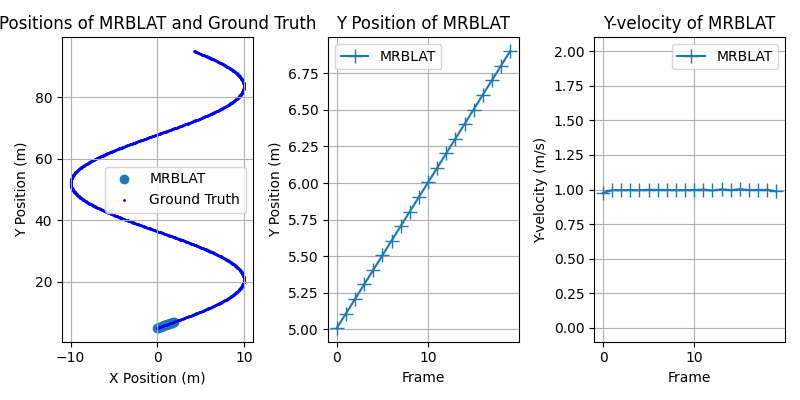

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(8, 4))
ax[0].scatter(single_phi_bar[:,0], single_phi_bar[:,1], label="BLAT")
ax[0].scatter(multi_phi_bar[:,0], multi_phi_bar[:,1], label="MRBLAT")
ax[0].scatter(target_ground_truth[0][:], target_ground_truth[1][:], label="Ground Truth", color="blue",s=1)
ax[0].set_title("Positions of MRBLAT and Ground Truth")
ax[0].set_xlabel("X Position (m)")
ax[0].set_ylabel("Y Position (m)")
ax[0].legend()
ax[0].grid(True)

ax[1].plot(single_phi_bar[:,1], label="BLAT", marker="+", markersize=10)
ax[1].plot(multi_phi_bar[:,1], label="MRBLAT", marker="+", markersize=10)
ax[1].set_xlabel("Frame")
ax[1].set_ylabel("Y Position (m)")
ax[1].set_title("Y Position of MRBLAT")
ax[1].legend()
ax[1].grid(True)

ax[2].plot(single_phi_bar[:,3], label="BLAT", marker="+", markersize=10)
ax[2].plot(multi_phi_bar[:,3], label="MRBLAT", marker="+", markersize=10)
ax[2].set_ylim(-.1, 2.1)
ax[2].set_xlabel("Frame")
ax[2].set_ylabel("Y-velocity (m/s)")
ax[2].set_title("Y-velocity of MRBLAT")
ax[2].legend()
ax[2].grid(True)

plt.tight_layout()
plt.show()
